# ADFA-LD - Logistic Regression 

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
import statistics
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
import glob
import math
from collections import Counter
import csv

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
# returns a dictionary of n-grams frequency for any list
def ngrams_freq(listname, n):
    counts = dict()
    # make n-grams as string iteratively
    grams = [' '.join(listname[i:i+n]) for i in range(len(listname)-n)]
    for gram in grams:
        if gram not in counts:
            counts[gram] = 1
        else:
            counts[gram] += 1
    return counts

# returns the values of features for any list
def feature_freq(listname,n,features):
	counts = dict()
	# make n-grams as string iteratively
	grams = [' '.join(listname[i:i+n]) for i in range(len(listname)-n)]
	for gram in grams:
		counts[gram] = 0
	for gram in grams:
		if gram in features:
			counts[gram] += 1
	return counts

# values of n for finding n-grams
n_values = [1]

# Base address for attack data files
add = "ADFA-LD/ADFA-LD/Attack_Data_Master/"
# list of attacks
attack = ['Adduser','Hydra_FTP','Hydra_SSH','Java_Meterpreter','Meterpreter','Web_Shell']

# initializing dictionary for n-grams from all files
traindict = {}

Attack_list_new = []
print("Generating Training Data ..................................")
for term in attack:
	print("	Training data from " + term)
	globals()['%s_list' % term] = []
	in_address = add+term
	k = 1
	# finding list of data from all files
	for i in range (1,11):
		read_files = glob.glob(in_address+"_"+str(i)+"/*.txt")
		for f in read_files:
			with open(f, "r") as infile:
				globals()['%s_list_array' % term+str(k)] = ALine =infile.read()
				#ALine = ALine[:820]                
				Attack_list_new.append(term +','+ str(ALine))
				globals()['%s_list' % term].extend(globals()['%s_list_array' % term+str(k)])
				k += 1
	# number of lists for distinct files
	globals()['%s_size' % term] = k-1
	# combined list of all files
	listname = globals()['%s_list' % term]
	# finding n-grams and extracting top 30%
	for n in n_values:
		#print("		Extracting top 30% "+str(n)+"-grams from "+term+".......................")
		dictname = ngrams_freq(listname,n)
		top = math.ceil(0.3*len(dictname))
		dictname = Counter(dictname)
		for k, v in dictname.most_common(top):
			traindict.update({k : v})

# finding training data for Normal file
print("	Training data from Normal")
Normal_list = []
Normal_list_new = []
in_address = "ADFA-LD/ADFA-LD/Training_Data_Master/"
k = 1
read_files = glob.glob(in_address+"/*.txt")
for f in read_files:
	with open(f, "r") as infile:
		globals()['Normal%s_list_array' % str(k)] = Line = infile.read()
		Normal_list_new.append('Normal,'+ str(Line))
		Normal_list.extend(globals()['Normal%s_list_array' % str(k)])
		k += 1

# number of lists for distinct files
Normal_list_size = k-1
# combined list of all files
listname = Normal_list


print("\nnew_train.csv created..............................................\n")


Generating Training Data ..................................
	Training data from Adduser
	Training data from Hydra_FTP
	Training data from Hydra_SSH
	Training data from Java_Meterpreter
	Training data from Meterpreter
	Training data from Web_Shell
	Training data from Normal

new_train.csv created..............................................



In [3]:
new_train_list = []
new_train_list = Normal_list_new + Attack_list_new
#new_train_list[1]
#Attack_list_new[1]


In [4]:
new_train_list = []
new_train_list = Normal_list_new + Attack_list_new


with open('new_train.csv', 'w') as f:
    for item in new_train_list:
        f.write("%s\n" % item)       

In [5]:
train = pd.read_csv("./new_train.csv", sep=',',error_bad_lines=False, header=None, names=['Label','CallTrace'])
train.head(5)
train.shape
#train.info()

#train.describe(include = 'all')
train_df = train.copy()
train['Label'] = train['Label'].astype('category')
train['CallTrace'] = train['CallTrace'].astype('category')

train['Label'].value_counts()
#train['CallTrace'].value_counts()

Normal              833
Hydra_SSH           176
Hydra_FTP           162
Java_Meterpreter    124
Web_Shell           118
Adduser              91
Meterpreter          75
Name: Label, dtype: int64

In [6]:
train['Label_Codes'] = train['Label'].cat.codes
train['CallTrace_Codes'] = train['CallTrace'].cat.codes
train['Label_Codes'].value_counts()

5    833
2    176
1    162
3    124
6    118
0     91
4     75
Name: Label_Codes, dtype: int64

In [7]:
train.head()

,Label,CallTrace,Label_Codes,CallTrace_Codes
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...,5,1407
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...,5,1239
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...,5,1286
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...,5,1465
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...,5,93


# Multinominal Logistic Regression

In [8]:
import warnings
warnings.filterwarnings("ignore")

# split the dataset in train and test
X = train.iloc[:, [3]].values
y = train.iloc[:, 2].values


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(multi_class='ovr', solver = 'lbfgs')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# How did our model perform?
from sklearn import metrics
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))




Misclassified samples: 145
Accuracy: 0.54


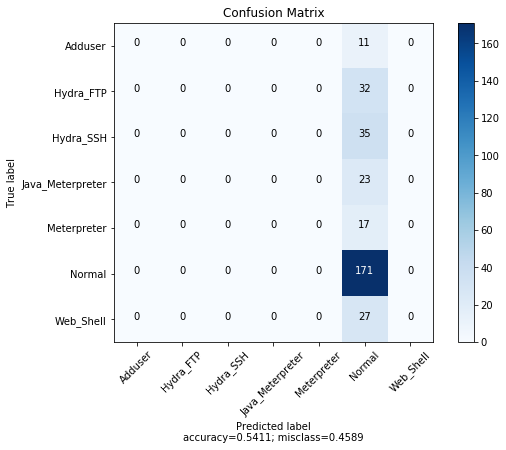

In [9]:
#classifier.predict_proba(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Adduser', 'Hydra_FTP', 'Hydra_SSH', 'Java_Meterpreter', 'Meterpreter', 'Normal', 'Web_Shell'],
                      title        = "Confusion Matrix")

# Logistic Regression Binary Classification

In [10]:
train.loc[train.Label != 'Normal','Label_Binary']= 1
train.loc[train.Label == 'Normal','Label_Binary']= 0
train['Label_Binary'].value_counts()
#train.head()

0.0    833
1.0    746
Name: Label_Binary, dtype: int64

In [11]:
train.head()

,Label,CallTrace,Label_Codes,CallTrace_Codes,Label_Binary
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...,5,1407,0.0
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...,5,1239,0.0
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...,5,1286,0.0
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...,5,1465,0.0
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...,5,93,0.0


In [12]:
import warnings
warnings.filterwarnings("ignore")

# split the dataset in train and test
X = train.iloc[:, [3]].values
y = train.iloc[:, 4].values


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
#classifier = LogisticRegression(multi_class='ovr', solver = 'lbfgs')
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# How did our model perform?
from sklearn import metrics
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))




Misclassified samples: 156
Accuracy: 0.51


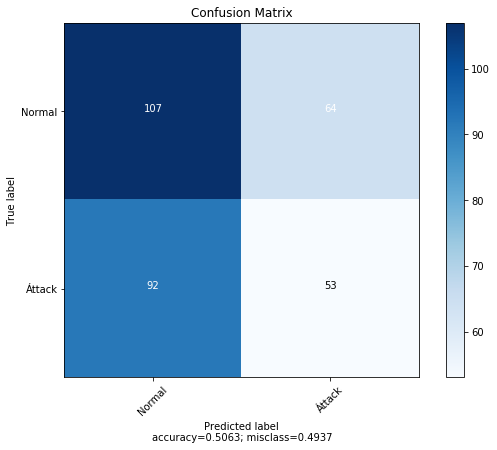

In [13]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Normal', 'Áttack'],
                      title        = "Confusion Matrix")

In [14]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.63      0.54      0.58       199
         1.0       0.37      0.45      0.40       117

   micro avg       0.51      0.51      0.51       316
   macro avg       0.50      0.50      0.49       316
weighted avg       0.53      0.51      0.51       316



# OneHotEncoding for LogisticRegression

In [15]:
# Split into predictor and response dataframes.
train_df_enc = train_df.copy()
X_df = train_df_enc.drop('Label', axis=1)
y = train_df_enc['Label']

X_df.shape,y.shape

((1579, 1), (1579,))

In [16]:
X_df.head()

,CallTrace
0,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...
1,54 175 120 175 175 3 175 175 120 175 120 175 1...
2,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...
3,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...
4,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...


In [17]:
train_df.head()

,Label,CallTrace
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...


In [18]:
# Map response variable to integers 0,1.
y = pd.Series(np.where(y.values != 'Normal',1,0), y.index)
y.value_counts()

0    833
1    746
dtype: int64

In [19]:
# Label Encode instead of dummy variables

mappings = []

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_df = train.drop('Label', axis=1)
label_df = train.drop('Label_Binary', axis=1)
label_df = train.drop('Label_Codes', axis=1)
label_df['CallTrace'] = label_df['CallTrace_Codes']
label_df = X_df.copy()
for i, col in enumerate(label_df):
    if label_df[col].dtype == 'object':
        label_df[col] = label_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

In [20]:
label_df.head()

,CallTrace
0,1407
1,1239
2,1286
3,1465
4,93


In [21]:
from sklearn.preprocessing import OneHotEncoder


onehot_encoder = OneHotEncoder()
for i, col in enumerate(label_df):
    if label_df[col].dtype == 'object':
        label_df[col] = onehot_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(onehot_encoder.classes_, range(1, len(onehot_encoder.classes_)+1))))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(label_df, y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1263, 1), (316, 1), (1263,), (316,))

In [23]:
clf = LogisticRegression()
model_mix = clf.fit(X_train, y_train)
# y_pred = model_norm.predict(X_test)
print("Model accuracy is", model_mix.score(X_test, y_test))

Model accuracy is 0.5569620253164557


In [24]:
model_mix

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
# logit_roc_auc = roc_auc_score(y_test, model_norm.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, model_norm.predict_proba(X_test)[:,1])

classes = model_mix.predict(X_test)
probs = model_mix.predict_proba(X_test)
preds = probs[:,1]
#preds

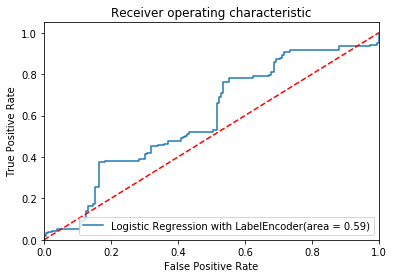

In [26]:
labelfpr, labeltpr, labelthreshold = metrics.roc_curve(y_test, preds)
label_roc_auc = metrics.auc(labelfpr, labeltpr)

plt.figure()
plt.plot(labelfpr, labeltpr, label='Logistic Regression with LabelEncoder(area = %0.2f)' % label_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

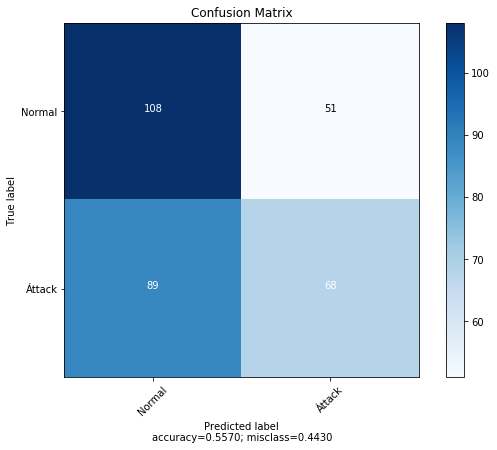

In [27]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, classes)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Normal', 'Áttack'],
                      title        = "Confusion Matrix")

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1263, 1), (316, 1), (1263,), (316,))

In [29]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.68      0.55      0.61       197
           1       0.43      0.57      0.49       119

   micro avg       0.56      0.56      0.56       316
   macro avg       0.56      0.56      0.55       316
weighted avg       0.59      0.56      0.56       316



# RandomForest Classification

In [30]:
# Normalize using MinMaxScaler to constrain values to between 0 and 1.
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
clf = RandomForestClassifier(n_jobs=-1)
model_rf = clf.fit(X_train, y_train)
print('Model accuracy is',model_rf.score(X_test, y_test))

Model accuracy is 0.8037974683544303


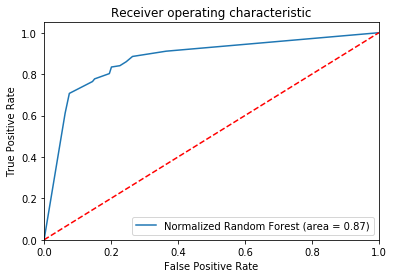

In [32]:
probs = model_rf.predict_proba(X_test)
preds = probs[:,1]
rffpr, rftpr, rfthreshold = metrics.roc_curve(y_test, preds)
rf_roc_auc = metrics.auc(rffpr, rftpr)

plt.figure()
plt.plot(rffpr, rftpr, label='Normalized Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

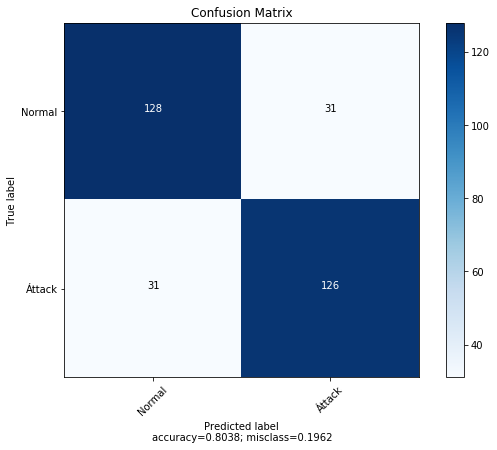

In [33]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
classes = model_rf.predict(X_test)
cm = confusion_matrix(y_test, classes)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Normal', 'Áttack'],
                      title        = "Confusion Matrix")

In [34]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       159
           1       0.80      0.80      0.80       157

   micro avg       0.80      0.80      0.80       316
   macro avg       0.80      0.80      0.80       316
weighted avg       0.80      0.80      0.80       316



# Train Data with ngrams

In [35]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.1, 0.9],
    n_features=20, n_samples=1000, random_state=10
)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = LogisticRegression(class_weight="balanced")
clf.fit(X_train, y_train)
THRESHOLD = 0.5
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.531646
recall,0.579618
precision,0.526012
roc_auc_score,0.531947


In [36]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

# load the dataset
#data = open('data/corpus').read()
#labels, texts = [], []
#for i, line in enumerate(data.split("\n")):
#    content = line.split()
#    labels.append(content[0])
#    texts.append(" ".join(content[1:]))

# create a dataframe using texts and lables
#trainDF = pandas.DataFrame()
#trainDF['text'] = texts
#trainDF['label'] = labels

Using TensorFlow backend.


In [37]:
X_df.head()

,CallTrace
0,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...
1,54 175 120 175 175 3 175 175 120 175 120 175 1...
2,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...
3,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...
4,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...


In [38]:
# create a dataframe using texts and lables
trainDF = train_df.copy()

trainDF['CallTrace_T'] = trainDF.CallTrace.str.split(' ').str.join(',').astype(str)
#X_df = trainDF.drop('Label', axis=1)
X_df = trainDF.drop(['Label', 'CallTrace'], axis=1)
y = trainDF['Label']

# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_df, y)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

X_df.head()

,CallTrace_T
0,"6,6,63,6,42,120,6,195,120,6,6,114,114,1,1,252,..."
1,"54,175,120,175,175,3,175,175,120,175,120,175,1..."
2,"6,11,45,33,192,33,5,197,192,6,33,5,3,197,192,1..."
3,"7,174,174,5,197,197,6,13,195,4,4,118,6,91,38,5..."
4,"11,45,33,192,33,5,197,192,6,33,5,3,197,192,192..."


In [39]:
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

((1184, 1), (395, 1), (1184,), (395,))

## Feature Engineering

2.1 Count Vectors as features

2.2 TF-IDF Vectors as features

 Word level

 N-Gram level

 Character level

 2.3 Word Embeddings as features

 2.4 Text / NLP based features

 2.5 Topic Models as features


In [40]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['CallTrace_T'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

print(xtrain_count.toarray())
print(count_vect.vocabulary_)
print(xtrain_count.shape)
#xt_count =pd.DataFrame(xtrain_count.A, columns=count_vect.get_feature_names())
#xt_count.shape
#print(pd.DataFrame(xtrain_count.A, columns=count_vect.get_feature_names()).to_string())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]]
{'6': 133, '63': 135, '42': 127, '120': 11, '195': 49, '114': 6, '1': 0, '252': 84, '54': 131, '175': 38, '3': 105, '7': 139, '119': 9, '174': 37, '140': 18, '11': 4, '45': 129, '33': 117, '192': 47, '5': 130, '197': 51, '243': 83, '125': 13, '91': 147, '258': 88, '311': 112, '240': 81, '191': 46, '122': 12, '268': 95, '201': 56, '196': 50, '38': 122, '13': 15, '4': 124, '118': 8, '194': 48, '221': 72, '66': 138, '12': 10, '60': 134, '220': 71, '199': 53, '10': 1, '85': 145, '83': 144, '96': 150, '97': 151, '289': 100, '163': 33, '141': 19, '331': 118, '78': 142, '57': 132, '168': 34, '146': 23, '102': 2, '202': 57, '158': 29, '265': 93, '219': 70, '300': 107, '133': 17, '1

In [41]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [1, 1184]

In [ ]:
# word level tf-idf
#tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
#tfidf_vect.fit(trainDF['CallTrace'])
#xtrain_tfidf =  tfidf_vect.transform(train_x)
#xvalid_tfidf =  tfidf_vect.transform(valid_x)
#print(xtrain_tfidf.toarray())
#print(tfidf_vect.vocabulary_)
#print(xtrain_tfidf.shape)

In [ ]:
# Linear Classifier on Count Vectors
#accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
#print("LR, Count Vectors: ", accuracy)

In [ ]:
# ngram level tf-idf 
#tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
#tfidf_vect_ngram.fit(trainDF['CallTrace_T'])
#xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
#xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

In [ ]:
# Linear Classifier on Ngram Level TF IDF Vectors
#accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
#print("LR, N-Gram Vectors: ", accuracy)

In [ ]:
# characters level tf-idf
#tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
#tfidf_vect_ngram_chars.fit(trainDF['CallTrace_T'])
#xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
#xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

In [ ]:
# Linear Classifier on Character Level TF IDF Vectors
#accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
#print("LR, CharLevel Vectors: ", accuracy)